In [1]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import warnings
warnings.filterwarnings("ignore")
# Connect to my database

conn = psycopg2.connect(
    host="",
    port="",  
    database="",  
    user="",  
    password=""  
)

cursor = conn.cursor()

In [2]:
import pandas as pd

# Query to get the data
query = """
SELECT date, location, opponent, 
       fg_1_19, fg_20_29, fg_30_39, fg_40_49, fg_50_plus, longest_fg, fg_percentage, fg_made, xp_made, points_scored, temp_f, precipitation_in, windspeed_mph, altitude_m, distance_from
FROM UCLA_Kicking_Stats;
"""

ucla_kicking = pd.read_sql(query, conn)

# FG data provided as a list of strings 
fg_data = [
    "2-2", "0-0", "1-1", "0-0", "2-4", "1-1", "0-2", "0-1", "1-3", "0", 
    "35", "0", "0", "1-3", "1-1", "4-4", "1-1", "1-1", "0-1", "3-3", 
    "1-2", "0-0", "0-1", "1-1", "2-3", "0-0", "1-1", "1-1", "1-1", "0-1", 
    "3-4", "2-2", "1-2", "1-2", "1-2", "1-2", "0-1", "2-2", "0-0", "0-0", 
    "0-0", "2-2", "1-1", "1-1", "2-3", "0-0", "0-1", "0-1", "1-1", "1-2", 
    "1-1", "2-2", "0-0", "1-2", "1-2", "0-1", "1-1", "1-1", "0-0", "0-0", 
    "3-3", "1-2", "3-3", "1-1", "1-2", "0-1", "0-1", "2-2", "2-3", "1-1", 
    "0-0", "1-1", "2-3", "2-2", "0-1", "1-1", "1-1", "1-1", "3-4", "1-2", 
    "3-3", "1-1", "3-4", "0-0", "1-2", "2-2", "1-2", "2-4", "0-0", "1-1", 
    "1-3", "1-1", "0-1", "1-1", "2-3", "3-3", "1-1", "0-0", "1-1", "2-2", 
    "4-4", "0-0", "2-2", "4-4", "1-2", "0-1", "0-1", "0-1", "0-0", "2-2", 
    "2-2", "0-1", "1-2", "3-3", "2-2", "1-2", "3-3", "1-1", "1-1", "2-2", 
    "1-2", "2-4", "1-1", "2-2", "3-3", "1-1", "0-0", "1-2", "1-1", "0-0", 
    "2-4", "0-0", "0-1"
]

# Ensure the length of fg_data matches the length of ucla_kicking df
if len(fg_data) == len(ucla_kicking):
    # Add the FG data to the df
    ucla_kicking['FG'] = fg_data

    # Split FG column into separate columns for makes and attempts
    ucla_kicking[['fg_makes', 'fg_attempts']] = ucla_kicking['FG'].str.split('-', expand=True)

    # Convert the makes and attempts columns to numeric, handling non-numerißc cases
    ucla_kicking['fg_makes'] = pd.to_numeric(ucla_kicking['fg_makes'], errors='coerce')
    ucla_kicking['fg_attempts'] = pd.to_numeric(ucla_kicking['fg_attempts'], errors='coerce')

    # Calculate FG percentage
    ucla_kicking['fg_percentage'] = (ucla_kicking['fg_makes'] / ucla_kicking['fg_attempts']) * 100

    # Handle any possible divisions by 0
    ucla_kicking['fg_percentage'] = ucla_kicking['fg_percentage'].fillna(0)


    print(ucla_kicking.head())
else:
    print(f"Length of fg_data ({len(fg_data)}) does not match length of DataFrame ({len(ucla_kicking)}).")


         date location                opponent  fg_1_19  fg_20_29  fg_30_39  \
0  2023-09-02        H        Coastal Carolina        0         0         1   
1  2023-09-09        @         San Diego State        0         0         0   
2  2023-09-16        H  North Carolina Central        0         1         0   
3  2023-09-23        @                    Utah        0         0         0   
4  2023-10-07        H        Washington State        0         0         2   

   fg_40_49  fg_50_plus  longest_fg  fg_percentage  ...  xp_made  \
0         1           0          47          100.0  ...        3   
1         0           0           0            0.0  ...        5   
2         0           0          24          100.0  ...        8   
3         0           0           0            0.0  ...        1   
4         0           0          37           50.0  ...        1   

   points_scored  temp_f  precipitation_in  windspeed_mph  altitude_m  \
0              9    73.4              0.03 

In [3]:
# Check the number of rows in the ucla_kicking DataFrame
num_rows_dataframe = len(ucla_kicking)

# Check the length of the fg_data list
num_entries_fg_data = len(fg_data)

# Compare the two lengths
if num_rows_dataframe == num_entries_fg_data:
    print("The number of FG data entries matches the number of rows in the DataFrame.")
else:
    print(f"Mismatch detected: DataFrame has {num_rows_dataframe} rows, but there are {num_entries_fg_data} FG data entries.")


The number of FG data entries matches the number of rows in the DataFrame.


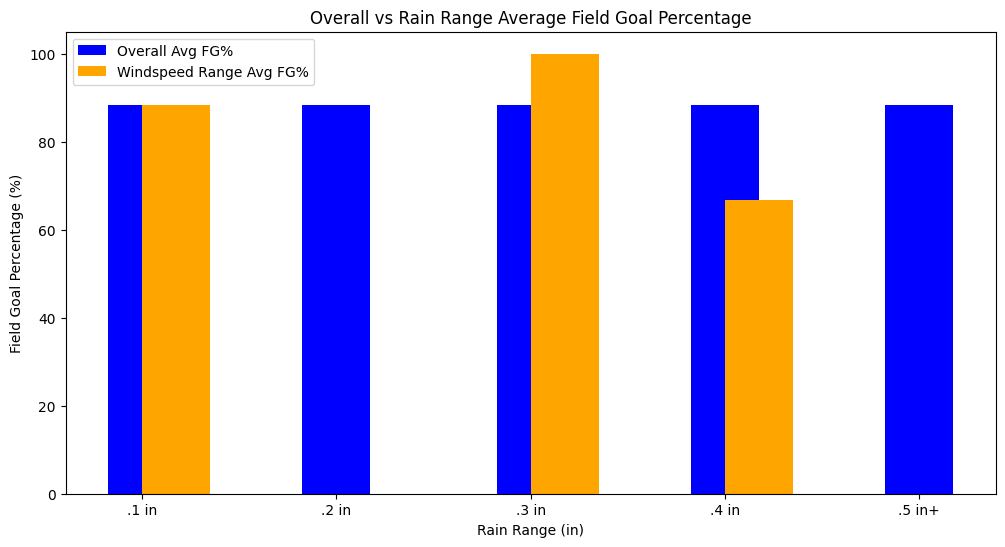

In [4]:
# Define the wind speed ranges
rain_bins = [0, .1, .2, .3, .4, float('inf')]
rain_labels = ['.1 in', '.2 in', '.3 in', '.4 in', '.5 in+']

# Create a new column in the dataframe for wind speed ranges
ucla_kicking['Rain_Range'] = pd.cut(ucla_kicking['precipitation_in'], bins=rain_bins, labels=rain_labels, right=False)

# Calculate total FG makes and attempts for each wind speed range
rain_fg_totals = ucla_kicking.groupby('Rain_Range').agg({'fg_makes': 'sum', 'fg_attempts': 'sum'})

# Calculate FG percentage for each wind speed range
rain_fg_totals['Rain_Range_Avg_FG%'] = (rain_fg_totals['fg_makes'] / rain_fg_totals['fg_attempts']) * 100

# Calculate the overall FG percentage across all wind speed ranges
overall_fg_makes = ucla_kicking['fg_makes'].sum()
overall_fg_attempts = ucla_kicking['fg_attempts'].sum()
overall_avg_fg = (overall_fg_makes / overall_fg_attempts) * 100

# Prepare data for plotting
avg_data = pd.DataFrame({
    'Rain_Range': rain_fg_totals.index,
    'Overall_Avg_FG%': [overall_avg_fg] * len(rain_fg_totals),
    'Rain_Range_Avg_FG%': rain_fg_totals['Rain_Range_Avg_FG%'].values
})

# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(avg_data['Rain_Range'], avg_data['Overall_Avg_FG%'], width=bar_width, label='Overall Avg FG%', color='blue', align='center')
plt.bar(avg_data['Rain_Range'], avg_data['Rain_Range_Avg_FG%'], width=bar_width, label='Windspeed Range Avg FG%', color='orange', align='edge')

plt.xlabel('Rain Range (in)')
plt.ylabel('Field Goal Percentage (%)')
plt.title('Overall vs Rain Range Average Field Goal Percentage')
plt.legend()

plt.show()
